In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [2]:
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# =========================
# Metrics
# =========================
def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-9))) * 100.0
    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "MAPE(%)": mape,
    }


# =========================
# Model loader (유연하게)
# =========================
def load_hour_bundle(path: str):
    """
    hour_XX_amt_cnt.joblib 로드.
    다양한 저장 형태를 최대한 흡수하려고:
    - dict 형태면 키를 탐색해서 preprocess/model_amt/model_cnt/feature_cols를 찾음
    - 단일 estimator(파이프라인) 저장이면 그걸 그대로 반환(이 경우 아래 predict쪽을 바꿔야 함)
    """
    obj = joblib.load(path)

    if isinstance(obj, dict):
        # 흔히 쓰는 키들
        preprocess = obj.get("preprocess") or obj.get("pipeline") or obj.get("preprocessor")
        model_amt = obj.get("model_amt") or obj.get("amt_model") or obj.get("modelAMT")
        model_cnt = obj.get("model_cnt") or obj.get("cnt_model") or obj.get("modelCNT")
        feature_cols = obj.get("feature_cols") or obj.get("features") or obj.get("X_cols")
        return {"type": "bundle", "preprocess": preprocess, "model_amt": model_amt, "model_cnt": model_cnt, "feature_cols": feature_cols, "raw": obj}

    # 단일 객체로 저장된 경우 (예: 멀티아웃풋 파이프라인 등)
    return {"type": "single", "estimator": obj}


# =========================
# Evaluation
# =========================
def evaluate_hour_models(
    model_dir: str,
    test_df: pd.DataFrame,
    target_amt_col: str = "AMT",
    target_cnt_col: str = "CNT",
    hour_col: str = "HOUR",
    hours=range(1, 11),
    file_pattern: str = "hour_{:02d}_amt_cnt.joblib",
):
    """
    시간대별로 test_df를 필터링(HOUR==01..10) 후 해당 시간 모델로 평가.
    """
    rows = []
    details = {}  # 시간대별 예측값 저장 원하면 쓰기

    for h in hours:
        model_path = os.path.join(model_dir, file_pattern.format(h))
        if not os.path.exists(model_path):
            print(f"[SKIP] 모델 없음: {model_path}")
            continue

        # 시간대 테스트셋
        df_h = test_df.loc[test_df[hour_col].astype(int) == int(h)].copy()
        if len(df_h) == 0:
            print(f"[SKIP] 테스트 데이터 없음: HOUR={h:02d}")
            continue

        y_amt = df_h[target_amt_col].values
        y_cnt = df_h[target_cnt_col].values

        bundle = load_hour_bundle(model_path)

        if bundle["type"] == "bundle":
            preprocess = bundle["preprocess"]
            model_amt = bundle["model_amt"]
            model_cnt = bundle["model_cnt"]
            feature_cols = bundle["feature_cols"]

            if feature_cols is None:
                # feature_cols가 저장 안 된 경우: 타겟/불필요 컬럼 제외하고 전부 사용(필요시 수정)
                drop_cols = {target_amt_col, target_cnt_col}
                X = df_h.drop(columns=[c for c in df_h.columns if c in drop_cols], errors="ignore")
            else:
                X = df_h[feature_cols].copy()

            # 전처리
            if preprocess is not None:
                Xp = preprocess.transform(X)
            else:
                Xp = X

            pred_amt = model_amt.predict(Xp)
            pred_cnt = model_cnt.predict(Xp)

        else:
            # 단일 estimator 저장 케이스: (예: Pipeline이 (X)->(amt,cnt) 둘 다 예측하도록 학습된 경우)
            est = bundle["estimator"]
            # 여기서는 우선 feature를 "타겟 제외 전체"로 가정
            X = df_h.drop(columns=[target_amt_col, target_cnt_col], errors="ignore")
            pred = est.predict(X)

            # pred shape에 따라 분해
            pred = np.asarray(pred)
            if pred.ndim == 2 and pred.shape[1] >= 2:
                pred_amt = pred[:, 0]
                pred_cnt = pred[:, 1]
            else:
                raise ValueError(
                    f"단일 estimator 예측 결과가 (n,2) 형태가 아닙니다. "
                    f"path={model_path}, pred_shape={pred.shape}"
                )

        m_amt = regression_metrics(y_amt, pred_amt)
        m_cnt = regression_metrics(y_cnt, pred_cnt)

        rows.append({
            "HOUR": f"{h:02d}",
            "N": len(df_h),

            "AMT_MAE": m_amt["MAE"],
            "AMT_RMSE": m_amt["RMSE"],
            "AMT_R2": m_amt["R2"],
            "AMT_MAPE(%)": m_amt["MAPE(%)"],

            "CNT_MAE": m_cnt["MAE"],
            "CNT_RMSE": m_cnt["RMSE"],
            "CNT_R2": m_cnt["R2"],
            "CNT_MAPE(%)": m_cnt["MAPE(%)"],
        })

        details[h] = {
            "y_amt": y_amt, "pred_amt": pred_amt,
            "y_cnt": y_cnt, "pred_cnt": pred_cnt
        }

    result_df = pd.DataFrame(rows).sort_values("HOUR")
    return result_df, details


# =========================
# 사용 예시
# =========================
if __name__ == "__main__":
    MODEL_DIR = "data/models_hourly_amt_cnt"  
    TEST_PATH = "data/수원시 한식 동별 데이터백업.csv"  

    test_df = pd.read_csv(TEST_PATH)

    report_df, _ = evaluate_hour_models(
        model_dir=MODEL_DIR,
        test_df=test_df,
        target_amt_col="AMT",   
        target_cnt_col="CNT",   
        hour_col="HOUR",
        hours=range(1, 11),
        file_pattern="hour_{:02d}_amt_cnt.joblib"
    )

    print("\n=== 시간대별 정확도 리포트 ===")
    print(report_df.to_string(index=False))

    # 저장
    out_path = os.path.join(MODEL_DIR, "hour_models_metrics.csv")
    report_df.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"\n저장 완료: {out_path}")



=== 시간대별 정확도 리포트 ===
HOUR     N      AMT_MAE     AMT_RMSE   AMT_R2  AMT_MAPE(%)   CNT_MAE  CNT_RMSE   CNT_R2  CNT_MAPE(%)
  01 42419 1.198133e+06 3.594501e+06 0.731673   186.813581 18.010562 64.333151 0.891294    70.782134
  02 42498 2.093282e+05 5.981361e+05 0.714182   129.741817  7.042609 12.244737 0.915746    44.814344
  03 44644 5.217909e+05 1.411181e+06 0.632710    79.799927 13.584253 24.294158 0.887106    30.996480
  04 45451 1.423732e+06 4.216697e+06 0.861911    41.701007 40.324578 76.763675 0.937633    22.952498
  05 45510 1.799703e+06 5.467815e+06 0.862112    41.687503 38.211555 93.573817 0.909412    19.029424
  06 45501 1.451059e+06 5.551910e+06 0.832943    52.841566 31.183302 94.183505 0.877408    22.975269
  07 45516 1.558560e+06 5.466870e+06 0.840776    39.467811 35.348575 93.474514 0.893985    19.847607
  08 45439 1.945660e+06 4.905444e+06 0.891921    56.548892 33.496197 85.085776 0.906805    19.898431
  09 44986 1.034007e+06 2.250965e+06 0.922132    81.229345 17.863871 

In [4]:
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =========================================================
# (옵션) 판다스 화면 표시 시 지수표기 대신 콤마 포맷 사용
# =========================================================
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")  # 화면 출력용(원하면 2자리로 바꿔도 됨)


# =========================
# Metrics
# =========================
def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    # 0/작은값 때문에 MAPE 튀는 문제 방지용 epsilon
    eps = 1e-9
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100.0

    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE(%)": mape}


# =========================
# Model loader (유연하게)
# =========================
def load_hour_bundle(path: str):
    """
    hour_XX_amt_cnt.joblib 로드.
    - dict 형태(bundle)면 preprocess/model_amt/model_cnt/feature_cols를 찾아 반환
    - 단일 estimator 저장이면 single 타입 반환
    """
    obj = joblib.load(path)

    if isinstance(obj, dict):
        preprocess = obj.get("preprocess") or obj.get("pipeline") or obj.get("preprocessor")
        model_amt = obj.get("model_amt") or obj.get("amt_model") or obj.get("modelAMT")
        model_cnt = obj.get("model_cnt") or obj.get("cnt_model") or obj.get("modelCNT")
        feature_cols = obj.get("feature_cols") or obj.get("features") or obj.get("X_cols")

        return {
            "type": "bundle",
            "preprocess": preprocess,
            "model_amt": model_amt,
            "model_cnt": model_cnt,
            "feature_cols": feature_cols,
            "raw": obj,
        }

    return {"type": "single", "estimator": obj}


# =========================
# Evaluation
# =========================
def evaluate_hour_models(
    model_dir: str,
    test_df: pd.DataFrame,
    target_amt_col: str = "AMT",
    target_cnt_col: str = "CNT",
    hour_col: str = "HOUR",
    hours=range(1, 11),
    file_pattern: str = "hour_{:02d}_amt_cnt.joblib",
):
    rows = []
    details = {}

    for h in hours:
        model_path = os.path.join(model_dir, file_pattern.format(h))
        if not os.path.exists(model_path):
            print(f"[SKIP] 모델 없음: {model_path}")
            continue

        # 시간대 테스트셋
        df_h = test_df.loc[test_df[hour_col].astype(int) == int(h)].copy()
        if len(df_h) == 0:
            print(f"[SKIP] 테스트 데이터 없음: HOUR={h:02d}")
            continue

        y_amt = df_h[target_amt_col].values
        y_cnt = df_h[target_cnt_col].values

        bundle = load_hour_bundle(model_path)

        if bundle["type"] == "bundle":
            preprocess = bundle["preprocess"]
            model_amt = bundle["model_amt"]
            model_cnt = bundle["model_cnt"]
            feature_cols = bundle["feature_cols"]

            if feature_cols is None:
                # feature_cols가 없으면 타겟만 제외하고 전부 사용(필요시 수정)
                X = df_h.drop(columns=[target_amt_col, target_cnt_col], errors="ignore")
            else:
                X = df_h[feature_cols].copy()

            Xp = preprocess.transform(X) if preprocess is not None else X

            pred_amt = model_amt.predict(Xp)
            pred_cnt = model_cnt.predict(Xp)

        else:
            # 단일 estimator 저장 케이스(멀티아웃풋일 때만 지원)
            est = bundle["estimator"]
            X = df_h.drop(columns=[target_amt_col, target_cnt_col], errors="ignore")
            pred = np.asarray(est.predict(X))

            if pred.ndim == 2 and pred.shape[1] >= 2:
                pred_amt = pred[:, 0]
                pred_cnt = pred[:, 1]
            else:
                raise ValueError(
                    f"단일 estimator 예측이 (n,2) 형태가 아닙니다. "
                    f"path={model_path}, pred_shape={pred.shape}"
                )

        m_amt = regression_metrics(y_amt, pred_amt)
        m_cnt = regression_metrics(y_cnt, pred_cnt)

        rows.append({
            "HOUR": f"{h:02d}",
            "N": len(df_h),

            "AMT_MAE": m_amt["MAE"],
            "AMT_RMSE": m_amt["RMSE"],
            "AMT_R2": m_amt["R2"],
            "AMT_MAPE(%)": m_amt["MAPE(%)"],

            "CNT_MAE": m_cnt["MAE"],
            "CNT_RMSE": m_cnt["RMSE"],
            "CNT_R2": m_cnt["R2"],
            "CNT_MAPE(%)": m_cnt["MAPE(%)"],
        })

        details[h] = {
            "y_amt": y_amt, "pred_amt": pred_amt,
            "y_cnt": y_cnt, "pred_cnt": pred_cnt,
        }

    result_df = pd.DataFrame(rows).sort_values("HOUR")
    return result_df, details


# =========================
# 보기 좋은 포맷(지수표기 제거) + pretty CSV 저장
# =========================
def make_pretty_metrics_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    숫자를 사람이 보기 좋게 문자열로 포맷:
    - AMT 계열(원 단위): 콤마 + 정수
    - CNT 계열: 소수 2자리
    - R2: 소수 4자리
    - MAPE: 소수 1자리
    - N: 콤마 + 정수
    """
    pretty = df.copy()

    # 혹시 HOUR가 1~10 정수로 들어와도 01~10으로 통일
    pretty["HOUR"] = pretty["HOUR"].astype(int).map(lambda x: f"{x:02d}") if pretty["HOUR"].dtype != object else pretty["HOUR"]

    fmt_int_comma = lambda x: f"{x:,.0f}"
    fmt_2 = lambda x: f"{x:,.2f}"
    fmt_4 = lambda x: f"{x:.4f}"
    fmt_1 = lambda x: f"{x:,.1f}"

    # N
    pretty["N"] = pretty["N"].map(fmt_int_comma)

    # AMT
    for c in ["AMT_MAE", "AMT_RMSE"]:
        if c in pretty.columns:
            pretty[c] = pretty[c].map(fmt_int_comma)

    # CNT
    for c in ["CNT_MAE", "CNT_RMSE"]:
        if c in pretty.columns:
            pretty[c] = pretty[c].map(fmt_2)

    # R2
    for c in ["AMT_R2", "CNT_R2"]:
        if c in pretty.columns:
            pretty[c] = pretty[c].map(fmt_4)

    # MAPE
    for c in ["AMT_MAPE(%)", "CNT_MAPE(%)"]:
        if c in pretty.columns:
            pretty[c] = pretty[c].map(fmt_1)

    return pretty


# =========================
# MAIN
# =========================
if __name__ == "__main__":
    MODEL_DIR = "data/models_hourly_amt_cnt"  
    TEST_PATH = "data/수원시 한식 동별 데이터백업.csv"   

    # 1) 테스트 데이터 로드
    test_df = pd.read_csv(TEST_PATH)

    # 2) 평가 실행
    metrics_df, _ = evaluate_hour_models(
        model_dir=MODEL_DIR,
        test_df=test_df,
        target_amt_col="AMT",   
        target_cnt_col="CNT",   
        hour_col="HOUR",
        hours=range(1, 11),
        file_pattern="hour_{:02d}_amt_cnt.joblib"
    )

    # 3) 원본(metrics) 저장
    raw_out = os.path.join(MODEL_DIR, "hour_models_metrics.csv")
    metrics_df.to_csv(raw_out, index=False, encoding="utf-8-sig")

    # 4) 보기 좋은(pretty) 버전 만들기 + 저장
    pretty_df = make_pretty_metrics_df(metrics_df)
    pretty_out = os.path.join(MODEL_DIR, "hour_models_metrics_pretty.csv")
    pretty_df.to_csv(pretty_out, index=False, encoding="utf-8-sig")

    # 5) 콘솔 출력(보기 좋게: formatters 적용해서 출력)
    fmt = {
        "N": lambda x: f"{int(str(x).replace(',','')):,.0f}" if isinstance(x, str) else f"{x:,.0f}",
        "AMT_MAE": lambda x: x, "AMT_RMSE": lambda x: x,
        "AMT_R2": lambda x: x, "AMT_MAPE(%)": lambda x: x,
        "CNT_MAE": lambda x: x, "CNT_RMSE": lambda x: x,
        "CNT_R2": lambda x: x, "CNT_MAPE(%)": lambda x: x,
    }
#     print("\n=== 시간대별 정확도(원본 숫자) ===")
#     print(metrics_df.to_string(index=False))

    print("\n=== 시간대별 정확도(보기 좋게) ===")
    print(pretty_df.to_string(index=False))

    print(f"\n저장 완료(원본):  {raw_out}")
    print(f"저장 완료(Pretty): {pretty_out}")



=== 시간대별 정확도(보기 좋게) ===
HOUR      N   AMT_MAE  AMT_RMSE AMT_R2 AMT_MAPE(%) CNT_MAE CNT_RMSE CNT_R2 CNT_MAPE(%)
  01 42,419 1,198,133 3,594,501 0.7317       186.8   18.01    64.33 0.8913        70.8
  02 42,498   209,328   598,136 0.7142       129.7    7.04    12.24 0.9157        44.8
  03 44,644   521,791 1,411,181 0.6327        79.8   13.58    24.29 0.8871        31.0
  04 45,451 1,423,732 4,216,697 0.8619        41.7   40.32    76.76 0.9376        23.0
  05 45,510 1,799,703 5,467,815 0.8621        41.7   38.21    93.57 0.9094        19.0
  06 45,501 1,451,059 5,551,910 0.8329        52.8   31.18    94.18 0.8774        23.0
  07 45,516 1,558,560 5,466,870 0.8408        39.5   35.35    93.47 0.8940        19.8
  08 45,439 1,945,660 4,905,444 0.8919        56.5   33.50    85.09 0.9068        19.9
  09 44,986 1,034,007 2,250,965 0.9221        81.2   17.86    50.84 0.9037        27.3
  10 41,559   422,439   931,164 0.8800       180.1    7.08    19.04 0.9063        44.6

저장 완료(원본):  data/

In [5]:
df = pd.read_csv('data/models_hourly_amt_cnt/hour_models_metrics_pretty.csv')
df

,HOUR,N,AMT_MAE,AMT_RMSE,AMT_R2,AMT_MAPE(%),CNT_MAE,CNT_RMSE,CNT_R2,CNT_MAPE(%)
0,1,"42,419","1,198,133","3,594,501",0.731700,186.800000,18.010000,64.330000,0.891300,70.800000
1,2,"42,498","209,328","598,136",0.714200,129.700000,7.040000,12.240000,0.915700,44.800000
2,3,"44,644","521,791","1,411,181",0.632700,79.800000,13.580000,24.290000,0.887100,31.000000
3,4,"45,451","1,423,732","4,216,697",0.861900,41.700000,40.320000,76.760000,0.937600,23.000000
4,5,"45,510","1,799,703","5,467,815",0.862100,41.700000,38.210000,93.570000,0.909400,19.000000
5,6,"45,501","1,451,059","5,551,910",0.832900,52.800000,31.180000,94.180000,0.877400,23.000000
6,7,"45,516","1,558,560","5,466,870",0.840800,39.500000,35.350000,93.470000,0.894000,19.800000
7,8,"45,439","1,945,660","4,905,444",0.891900,56.500000,33.500000,85.090000,0.906800,19.900000
8,9,"44,986","1,034,007","2,250,965",0.922100,81.200000,17.860000,50.840000,0.903700,27.300000
9,10,"41,559","422,439","931,164",0.880000,180.100000,7.080000,19.040000,0.906300,44.600000


C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from cur

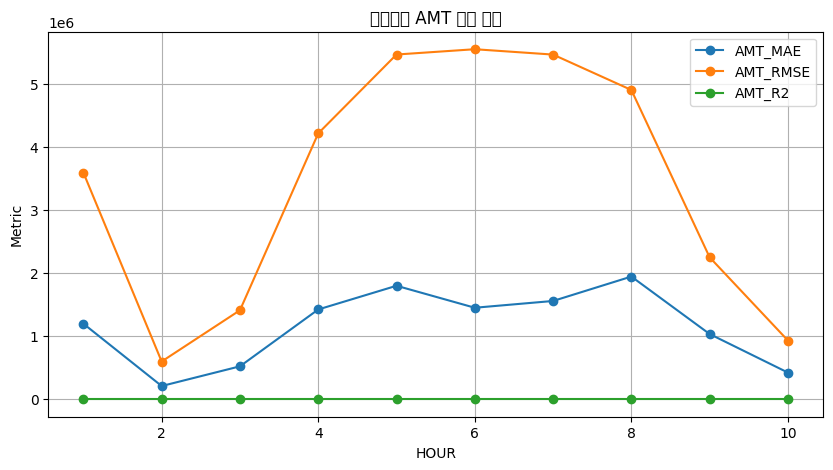

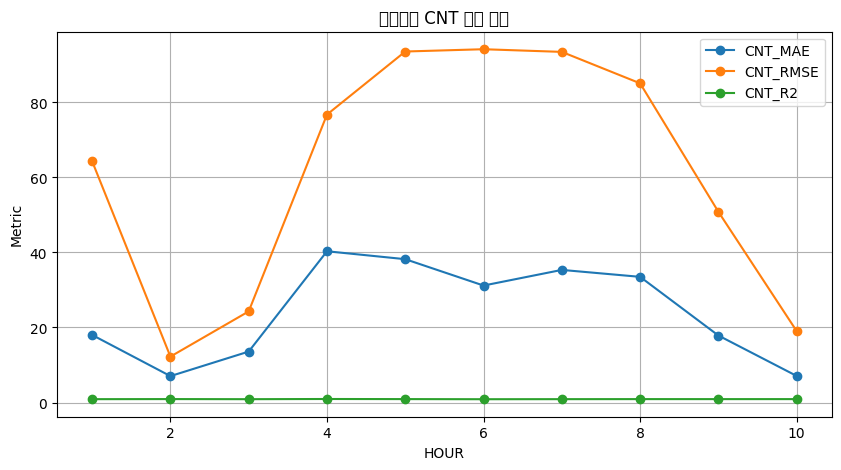

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

path = "data/models_hourly_amt_cnt/hour_models_metrics_pretty.csv"
df = pd.read_csv(path)

# 1) 콤마/퍼센트 제거 후 숫자 변환
for c in df.columns:
    if c == "HOUR":
        continue
    df[c] = (
        df[c].astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("%", "", regex=False)
    )
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 2) HOUR 정렬
df = df.sort_values("HOUR")

# =========================
# AMT 지표 라인플롯
# =========================
amt_metrics = ["AMT_MAE", "AMT_RMSE", "AMT_R2"]  

plt.figure(figsize=(10, 5))
for m in amt_metrics:
    if m in df.columns:
        plt.plot(df["HOUR"], df[m], marker="o", label=m)
plt.title("시간대별 AMT 성능 지표")
plt.xlabel("HOUR")
plt.ylabel("Metric")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# CNT 지표 라인플롯
# =========================
cnt_metrics = ["CNT_MAE", "CNT_RMSE", "CNT_R2"]  

plt.figure(figsize=(10, 5))
for m in cnt_metrics:
    if m in df.columns:
        plt.plot(df["HOUR"], df[m], marker="o", label=m)
plt.title("시간대별 CNT 성능 지표")
plt.xlabel("HOUR")
plt.ylabel("Metric")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, r2_score

# =========================
# 경로 (네 요구 그대로)
# =========================
DATA_CSV  = r"data/수원시 한식 동별 데이터백업.csv"
MODEL_DIR = r"data/models_hourly_amt_cnt"  # hour_01_amt_cnt.joblib ~ hour_10_amt_cnt.joblib

# =========================
# 유틸: 지표 계산
# =========================
def calc_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2":  float(r2_score(y_true, y_pred)),
        "N":   int(len(y_true)),
    }

# =========================
# 유틸: 모델/번들에서 예측
#   - Pipeline: obj.predict(X) 직접 호출
#   - Dict 번들: preprocess.transform 후 model_amt/model_cnt 예측
# =========================
def predict_amt_cnt(model_obj, X):
    # 1) Pipeline/Estimator인 경우
    if hasattr(model_obj, "predict") and not isinstance(model_obj, dict):
        yhat = model_obj.predict(X)
        yhat = np.asarray(yhat)

        # (n,) -> AMT만 있다고 간주
        if yhat.ndim == 1:
            return yhat, None

        # (n,2) -> [AMT, CNT]
        if yhat.ndim == 2 and yhat.shape[1] >= 2:
            return yhat[:, 0], yhat[:, 1]

        # 그 외 형태는 예외
        raise ValueError(f"Pipeline predict 결과 shape이 예상과 다릅니다: {yhat.shape}")

    # 2) Dict 번들인 경우 (혹시 어떤 hour는 dict일 수도 있으니 유지)
    if isinstance(model_obj, dict):
        # 키 이름이 조금 달라도 대응
        pre = None
        for k in ["preprocess", "preprocessor", "pipeline", "pipe"]:
            if k in model_obj:
                pre = model_obj[k]
                break

        m_amt = None
        for k in ["model_amt", "amt_model", "modelAMT", "amt"]:
            if k in model_obj:
                m_amt = model_obj[k]
                break

        m_cnt = None
        for k in ["model_cnt", "cnt_model", "modelCNT", "cnt"]:
            if k in model_obj:
                m_cnt = model_obj[k]
                break

        if pre is None or m_amt is None:
            raise KeyError(f"dict 번들에서 preprocess/model_amt를 찾지 못했습니다. keys={list(model_obj.keys())}")

        X_t = pre.transform(X)
        pred_amt = m_amt.predict(X_t)
        pred_cnt = m_cnt.predict(X_t) if m_cnt is not None else None
        return np.asarray(pred_amt), (np.asarray(pred_cnt) if pred_cnt is not None else None)

    raise TypeError(f"지원하지 않는 모델 객체 타입: {type(model_obj)}")

# =========================
# 1) 실제 데이터 로드
# =========================
df = pd.read_csv(DATA_CSV, encoding="utf-8-sig")

# 필수 컬럼 체크
need = ["HOUR", "AMT", "CNT"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise KeyError(f"실제 데이터에 필수 컬럼이 없습니다: {missing}\n현재 컬럼: {list(df.columns)}")

# HOUR 정리
df["HOUR"] = pd.to_numeric(df["HOUR"], errors="coerce")
df = df.dropna(subset=["HOUR", "AMT", "CNT"]).copy()
df["HOUR"] = df["HOUR"].astype(int)

# 1~10만
df = df[df["HOUR"].between(1, 10)].copy()

# 타겟
y_amt_all = df["AMT"].astype(float)
y_cnt_all = df["CNT"].astype(float)

# 입력 X: 타겟만 제거 (나머지 컬럼은 학습 때 쓰던 그대로 있어야 함)
X_all = df.drop(columns=["AMT", "CNT"], errors="ignore")

# =========================
# 2) 시간대별 평가
# =========================
rows = []

for h in range(1, 11):
    model_path = os.path.join(MODEL_DIR, f"hour_{h:02d}_amt_cnt.joblib")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"모델 파일 없음: {model_path}")

    model_obj = joblib.load(model_path)

    mask = (df["HOUR"] == h)
    X_h = X_all.loc[mask].copy()
    y_amt_h = y_amt_all.loc[mask].copy()
    y_cnt_h = y_cnt_all.loc[mask].copy()

    if len(X_h) == 0:
        rows.append({
            "HOUR": h,
            "AMT_MAE": np.nan, "AMT_R2": np.nan, "AMT_N": 0,
            "CNT_MAE": np.nan, "CNT_R2": np.nan, "CNT_N": 0,
        })
        continue

    pred_amt, pred_cnt = predict_amt_cnt(model_obj, X_h)

    amt_m = calc_metrics(y_amt_h, pred_amt)

    # CNT가 없으면 스킵 (혹시 Pipeline이 AMT만 예측하는 구조일 수도 있어서)
    if pred_cnt is not None:
        cnt_m = calc_metrics(y_cnt_h, pred_cnt)
        rows.append({
            "HOUR": h,
            "AMT_MAE": amt_m["MAE"], "AMT_R2": amt_m["R2"], "AMT_N": amt_m["N"],
            "CNT_MAE": cnt_m["MAE"], "CNT_R2": cnt_m["R2"], "CNT_N": cnt_m["N"],
        })
    else:
        rows.append({
            "HOUR": h,
            "AMT_MAE": amt_m["MAE"], "AMT_R2": amt_m["R2"], "AMT_N": amt_m["N"],
            "CNT_MAE": np.nan, "CNT_R2": np.nan, "CNT_N": 0,
        })

result = pd.DataFrame(rows).sort_values("HOUR")

print("\n✅ 시간대별 평가 결과 (실제: 수원시 한식 동별 데이터백업.csv)")
print(result)

# 저장
out_path = os.path.join(MODEL_DIR, "hourly_eval_amt_cnt.csv")
result.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"\n📁 저장 완료: {out_path}")



✅ 시간대별 평가 결과 (실제: 수원시 한식 동별 데이터백업.csv)
   HOUR          AMT_MAE   AMT_R2  AMT_N   CNT_MAE   CNT_R2  CNT_N
0     1 1,198,133.338199 0.731673  42419 18.010562 0.891294  42419
1     2   209,328.226511 0.714182  42498  7.042609 0.915746  42498
2     3   521,790.931767 0.632710  44644 13.584253 0.887106  44644
3     4 1,423,731.506872 0.861911  45451 40.324578 0.937633  45451
4     5 1,799,703.040061 0.862112  45510 38.211555 0.909412  45510
5     6 1,451,058.547784 0.832943  45501 31.183302 0.877408  45501
6     7 1,558,559.692371 0.840776  45516 35.348575 0.893985  45516
7     8 1,945,659.685544 0.891921  45439 33.496197 0.906805  45439
8     9 1,034,006.735972 0.922132  44986 17.863871 0.903733  44986
9    10   422,439.358272 0.880005  41559  7.081298 0.906329  41559

📁 저장 완료: data/models_hourly_amt_cnt\hourly_eval_amt_cnt.csv


In [20]:
df = pd.read_csv('data/models_hourly_amt_cnt/hourly_eval_amt_cnt.csv')
pd.options.display.float_format = '{:.6g}'.format

df.drop(['AMT_N','CNT_N'], axis=1, inplace=True)
df['AMT_MAE'] = round(df['AMT_MAE']).astype('int')
df['CNT_MAE'] = round(df['CNT_MAE']).astype('int')
df['AMT_R2'] = round(df['AMT_R2']*100, 2)
df['CNT_R2'] = round(df['CNT_R2']*100, 2)
df

,HOUR,AMT_MAE,AMT_R2,CNT_MAE,CNT_R2
0,1,1198133,73.17,18,89.13
1,2,209328,71.42,7,91.57
2,3,521791,63.27,14,88.71
3,4,1423732,86.19,40,93.76
4,5,1799703,86.21,38,90.94
5,6,1451059,83.29,31,87.74
6,7,1558560,84.08,35,89.4
7,8,1945660,89.19,33,90.68
8,9,1034007,92.21,18,90.37
9,10,422439,88,7,90.63
